In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Collaborative Filtering for Movie Recommendations

**Author:** [Siddhartha Banerjee](https://twitter.com/sidd2006)<br>
**Date created:** 2020/05/24<br>
**Last modified:** 2020/05/24<br>
**Description:** Recommending movies using a model trained on Movielens dataset.

## Introduction

This example demonstrates
[Collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering)
using the [Movielens dataset](https://www.kaggle.com/c/movielens-100k)
to recommend movies to users.
The MovieLens ratings dataset lists the ratings given by a set of users to a set of movies.
Our goal is to be able to predict ratings for movies a user has not yet watched.
The movies with the highest predicted ratings can then be recommended to the user.

The steps in the model are as follows:

1. Map user ID to a "user vector" via an embedding matrix
2. Map movie ID to a "movie vector" via an embedding matrix
3. Compute the dot product between the user vector and movie vector, to obtain
the a match score between the user and the movie (predicted rating).
4. Train the embeddings via gradient descent using all known user-movie pairs.

**References:**

- [Collaborative Filtering](https://dl.acm.org/doi/pdf/10.1145/371920.372071)
- [Neural Collaborative Filtering](https://dl.acm.org/doi/pdf/10.1145/3038912.3052569)

## 라이브러리 불러오기

In [ ]:
#필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
from zipfile import ZipFile #zipfile 모듈에서 ZipFile 클래스를 가져옴 (zipfile 모듈은 ZIP 파일 형식을 다루는 데 사용)
import tensorflow as tf #텐서플로우 라이브러리
from tensorflow import keras #keras
from tensorflow.keras import layers #layers
from pathlib import Path # pathlib로부터 Path 클래스 호출 (파일 및 디렉토리 경로를 다루는데 사용되는 모듈)
import matplotlib.pyplot as plt

## 데이터 불러오기 및 전처리


In [ ]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = ("http://files.grouplens.org/datasets/movielens/ml-latest-small.zip") #데이터 다운로드
movielens_zipped_file = keras.utils.get_file("ml-latest-small.zip", movielens_data_file_url, extract=False)
#keras.utils.get_file(): 주어진 URL에서 파일을 다운로드하고 지정된 로컬 경로에 저장
#"ml-latest-small.zip": 로컬로 저장될 파일명
#이 URL은 Movielens 데이터셋의 작은 버전인 "ml-latest-small.zip"를 가리킵니다.
# extract=False: 파일 다운 후 압축 해제 여부. False = 압축풀지않음

#zip파일이 저장된 디렉토리의 경로 (부모 디렉토리) 를 keras_datasets_path에 저장
keras_datasets_path = Path(movielens_zipped_file).parents[0]

#movie_datasets_path에 "ml-latest-small"문자열을 붙여서 Movielens데이터셋의 디렉토리 경로 생성
#movielens_dir 변수에 저장
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

#movielens_dir 경로에 있는 ratings.csv파일의 경로를 저장
ratings_file = movielens_dir / "ratings.csv"
#df 변수에 ratings_file 저장
df = pd.read_csv(ratings_file)

978202/978202 [==============================] - 0s 0us/step
Extracting all the files now...
Done!


In [ ]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


- 사용자, 영화를 정수 인덱스로 인코딩하기 위한 전처리 수행

In [ ]:
# df에서 userId 컬럼의 고유값을 추출하여 리스트로 전환 (고유한 사용자 ID 목록이 됨)
user_ids = df["userId"].unique().tolist()

#user_ids 리스트에 대해 사용자 ID를 새로운 인코딩된 값으로 매핑하는 딕셔너리 생성.
#인코딩된 값은 0부터 시작하여 고유한 사용자ID에 매핑
user2user_encoded = {x: i for i, x in enumerate(user_ids)}

#인코딩된 사용자ID를 원래 사용자 ID로 매핑
userencoded2user = {i: x for i, x in enumerate(user_ids)}

#movieId 열에서  고유한 영화ID 추출하여 리스트로 만듬
movie_ids = df["movieId"].unique().tolist()

#영화ID를 인코딩된 값으로 매핑하는 딕셔너리 생성
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
#인코딩 된 영화ID를 원래 영화ID값으로 매핑하는 딕셔너리 생성
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
#df에 user컬럼 생성하고 앞에서 매핑된 결과를 입력
df["user"] = df["userId"].map(user2user_encoded)
#df에 movie컬럼을 생성, 앞에서 매핑된 결과를 입력
df["movie"] = df["movieId"].map(movie2movie_encoded)

#딕셔너리를 사용하여 사용자의 수 계산
num_users = len(user2user_encoded)
#딕셔너리를 사용하여 영화의 수 계산
num_movies = len(movie_encoded2movie)
#rating컬럼의 데이터타입을 실수로 변환 (머신러닝 모델에서 사용하기 위해)
df["rating"] = df["rating"].values.astype(np.float32)

#rating의 최대값가 최소값을 찾아서 평점을 정규화 할 때 사용
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"]) #최소값 저장
max_rating = max(df["rating"]) #최대값 저장

#user, 영화 수, 최소, 최대값 출력
print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [ ]:
df.head()

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4


## 훈련 및 검증 데이터 준비

In [ ]:
#머신러닝 모델 구축 전 준비과정
#훈련 데이터 set
#sample() 메서드 사용, 무작위로 섞은 후 frac=1 : 전체데이터 선택, 난수 생성값 설정
df = df.sample(frac=1, random_state=42)

#user, movie 데이터 추출하여 numpy 배열로 변환 (모델의 입력 데이터)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
#rating데이터(평점) 를 추출하여 정규화
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.

#데이터를 훈련 세트와 검증 세트로 나눔 (90%훈련, 10%검증)
train_indices = int(0.9 * df.shape[0]) # 90% 기준
#x_train : 훈련용 입력데이터,  x_val: 검증용 입력데이터
#y_train : 훈련용 타겟, y_val: 검증용 타겟
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

## 모델 만들기

- 이 모델은 사용자와 영화 간의 상호 작용을 학습하여 사용자에게 영화를 추천하기 위한 구조
- 이 모델을 훈련, 평가 데이터를 사용하여 영화를 추천

In [ ]:
#범주형 데이터 (사용자ID, 영화ID)를 연속벡터로 변환 (50차원으로 임베딩 : 영화와 사용자의 특성을 50개의 숫자로 표현)
EMBEDDING_SIZE = 50

# TensorFlow 및 keras를 사용, 추천시스템을 위한 사용자와 영화에 대한 임베딩을 정의하는 모델인
# RecommenderNe을 생성하는 코드

class RecommenderNet(keras.Model): #RecommenderNet 클래스 정의 : keras.Model클래스를 상속하여 사용자 정의 모델 생성
    def __init__(self, num_users, num_movies, embedding_size, **kwargs): #모델 초기화 / 사용자, 영화의 수, 임베딩 크기 설정
        super().__init__(**kwargs)
        self.num_users = num_users #사용자의 수
        self.num_movies = num_movies #영화의 수
        self.embedding_size = embedding_size # 임베딩 벡터의 크기(50)
        self.user_embedding = layers.Embedding( #사용자 임베딩 레이어 생성 (범주형 데이터를 임베딩 벡터로 변환)
            num_users, # 임베딩레이어에 전달되는 범주의 수
            embedding_size, #임베딩벡터의 크기
            embeddings_initializer="he_normal", #임베딩 가중치 초기화 방법 지정
            embeddings_regularizer=keras.regularizers.l2(1e-6), # 임베딩 가중치에 대한 정규화 설정
        )
        self.user_bias = layers.Embedding(num_users, 1) #사용자 및 영화에 대한 편향을 위한 임베딩 레이어 생성 (사용자 별 평점 평균 조정)
        self.movie_embedding = layers.Embedding( #영화 임베딩 레이어 생성
            num_movies, # 임베딩 레이어에 전달되는 범주의 수
            embedding_size, #임베딩벡터의 크기
            embeddings_initializer="he_normal", #임베딩 가중치 초기화 방법 지정 (Xavier초기화, 균등분포초기화 등)
            embeddings_regularizer=keras.regularizers.l2(1e-6), # 임베딩 가중치에 대한 정규화 설정
        )
        self.movie_bias = layers.Embedding(num_movies, 1) #영화별 평점 평균 조정

## 편향 : 사용자와 영화간의 평가/선호도를 모델링하는 데 사용되는 중요 요소
## 사용자 편향 : 모델이 각 사용자의 특정 행동을 고려하고 해당 사용자의 특성 반영 (여기서는 평가)
## 영화편향 : 영화의 장르, 시대 등 영화의 특징을 반영

    def call(self, inputs): #입력-출력 함수 정의
        #입력으로부터 사용자 임베딩 및 편향 추출
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        #입력으로부터 영화 임베딩 및 편향을 추출
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        #사용자 임베딩과 영화 임베딩 간의 내적 계산 (사용자와 영화 간 상호작용)
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        #모든 구성요소를 더하여 모델의 출력을 생성
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        #sigmoid활성화 함수를 사용하여 모델의 출력을 0,1 사이로 변환 (평점을 확률값으로 변환하는 데 사용)
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE) # RecommenderNet 모델 생성
model.compile( #모델 컴파일 (학습을 수행하기 위해 필요한 설정 구성)
    loss=tf.keras.losses.BinaryCrossentropy(), # 손실함수 사용, 모델이 예측한 평점과 실제 평점간의 차이 최소화
    optimizer=keras.optimizers.Adam(learning_rate=0.001), # 옵티마이저로 adam사용 (경사하강법), 손실함수 최소화, 매개변수 사용하여 학습률 설정
)

#데이터를 학습 및 평가하는데 사용할 수 있는 모델 생성

## 모델 학습

In [ ]:
# 모델 학습

history = model.fit( #모델 학습 메서드
    x=x_train, #훈련데이터 입력
    y=y_train, #훈련데이터 타겟
    batch_size=64, #미니배치의 크기
    epochs=5, # 전체 데이터셋 반복학습 횟수
    verbose=1, # 학습과정 출력 (1은 손실 및 메트릭 출력)
    validation_data=(x_val, y_val), #검증 데이터로 모델 성능 평가
)

Epoch 1/5
1418/1418 [==============================] - 18s 9ms/step - loss: 0.6360 - val_loss: 0.6207
Epoch 2/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6132 - val_loss: 0.6201
Epoch 3/5
1418/1418 [==============================] - 5s 3ms/step - loss: 0.6085 - val_loss: 0.6146
Epoch 4/5
1418/1418 [==============================] - 5s 4ms/step - loss: 0.6074 - val_loss: 0.6161
Epoch 5/5
1418/1418 [==============================] - 5s 3ms/step - loss: 0.6073 - val_loss: 0.6131


## train, test loss plot

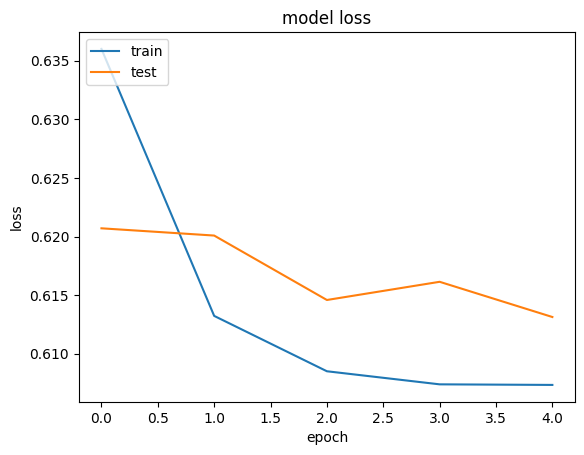

In [ ]:
#모델 학습중 손실에 대한 시각화 : 모델의 진행상황 및 과적합 여부 파악 가능
plt.plot(history.history["loss"]) #훈련 데이터 손실값 그래프  / 각 epoch 마다의 훈련 데이터 손실값
plt.plot(history.history["val_loss"]) #검증 데이터에 대한 손실값 그래프 / 각 학습에폭마다의 손실값
plt.title("model loss") # 그래프 제목
plt.ylabel("loss") # y축 레이블
plt.xlabel("epoch") # x축 레이블
plt.legend(["train", "test"], loc="upper left") #그래프에 범례 추가
plt.show() # 그래프 표시

#학습이 진행됨에 따라 손실이 감소하는 것이 이상적이며, 손실이 증가하면 과적합 가능성 고려

## 상위 10개 영화 추천 출력하기

In [ ]:
#특정 사용자에게 영화 추천을 수행하는 예시
#영화 데이터를 로드하여 movie_df 데이터프레임에 저장
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
#무작위로 선택한 사용자 ID를 user_id 변수에 저장
user_id = df.userId.sample(1).iloc[0]

#선택한 사용자가 시청한 영화 목록을 movies_watched_by_user 데이터프레임에 저장
movies_watched_by_user = df[df.userId == user_id]

#사용자가 아직 시청하지 않은 영화 ID 목록 추출
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]

#사용자가 아직 시청하지 않은 영화 중에서 모델이 인식하는 영화 ID 목록 추출
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)

#모델이 사용하는 영화 ID에 해당하는 인덱스를 찾아 movies_not_watched를 업데이트
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

#사용자 ID에 해당하는 인코딩데이터 불러오기
user_encoder = user2user_encoded.get(user_id)

#사용자와 아직 시청하지 않은 영화에 대한 입력 배열을 생성
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)

#모델을 사용하여 사용자가 아직 시청하지 않은 영화에 대한 예상 평점 계산
ratings = model.predict(user_movie_array).flatten()

#예상 평점이 가장 높은 상위 10개의 영화를 선택
top_ratings_indices = ratings.argsort()[-10:][::-1]

#선택한 영화에 대한 영화 ID를 실제 영화 제목으로 변환하여 recommended_movie_ids에 저장합니다.
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

#사용자에게 추천 결과를 출력
print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

270/270 [==============================] - 1s 2ms/step
Showing recommendations for user: 606
Movies with high ratings from user
--------------------------------
My Fair Lady (1964) : Comedy|Drama|Musical|Romance
2001: A Space Odyssey (1968) : Adventure|Drama|Sci-Fi
Being John Malkovich (1999) : Comedy|Drama|Fantasy
Princess Mononoke (Mononoke-hime) (1997) : Action|Adventure|Animation|Drama|Fantasy
Guess Who's Coming to Dinner (1967) : Drama
--------------------------------
Top 10 movie recommendations
--------------------------------
Fargo (1996) : Comedy|Crime|Drama|Thriller
Rebel Without a Cause (1955) : Drama
Streetcar Named Desire, A (1951) : Drama
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
Goodfellas (1990) : Crime|Drama
Chinatown (1974) : Crime|Film-Noir|Mystery|Thriller
Cool Hand Luke (1967) : Drama
Snatch (2000) : Comedy|Crime|Thriller
Dark Knight, The (2008) : Action|Crime|Drama|IMAX
Up (2009) : Adventure|Animation|Children|Drama


**Example available on HuggingFace**

| Trained Model | Demo |
| :--: | :--: |
| [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Model-Collaborative%20Filtering-black.svg)](https://huggingface.co/keras-io/collaborative-filtering-movielens) | [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Spaces-Collaborative%20Filtering-black.svg)](https://huggingface.co/spaces/keras-io/collaborative-filtering-movielens) |

## 다른 데이터에 적용
### 아마존 킨들스토어 제품 리뷰 데이터 (from kaggle)

In [ ]:
#데이터 불러오기
df_kd = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Business Analytics/kindle_reviews.csv")
df_kd.head()

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,B000F83SZQ,"[0, 0]",5,I enjoy vintage books and movies so I enjoyed ...,"05 5, 2014",A1F6404F1VG29J,Avidreader,Nice vintage story,1399248000
1,1,B000F83SZQ,"[2, 2]",4,This book is a reissue of an old one; the auth...,"01 6, 2014",AN0N05A9LIJEQ,critters,Different...,1388966400
2,2,B000F83SZQ,"[2, 2]",4,This was a fairly interesting read. It had ol...,"04 4, 2014",A795DMNCJILA6,dot,Oldie,1396569600
3,3,B000F83SZQ,"[1, 1]",5,I'd never read any of the Amy Brewster mysteri...,"02 19, 2014",A1FV0SX13TWVXQ,"Elaine H. Turley ""Montana Songbird""",I really liked it.,1392768000
4,4,B000F83SZQ,"[0, 1]",4,"If you like period pieces - clothing, lingo, y...","03 19, 2014",A3SPTOKDG7WBLN,Father Dowling Fan,Period Mystery,1395187200


- reviewerId, asin, overall 컬럼 사용

## 데이터 전처리

In [ ]:
# df_kd에서 reviewerID 컬럼의 고유값을 추출하여 리스트로 전환 (고유한 reviewerID 목록이 됨)
rvids = df_kd["reviewerID"].unique().tolist()

#rvid리스트에 대해 reviewerID를 새로운 인코딩된 값으로 매핑하는 딕셔너리 생성.
#인코딩된 값은 0부터 시작하여 고유한 사용자ID에 매핑
rv_encoded = {x: i for i, x in enumerate(rvids)}
#인코딩된 reviewerID를 원래 reviewerID로 매핑
rvencoded2rv = {i: x for i, x in enumerate(rvids)}

#asin 열에서  고유한 asin번호 추출하여 리스트로 만듬
asinids = df_kd["asin"].unique().tolist()

#asin를 인코딩된 값으로 매핑하는 딕셔너리 생성
asin_encoded = {x: i for i, x in enumerate(asinids)}
#인코딩 된 asin를 원래 asin값으로 매핑하는 딕셔너리 생성
asin_encoded2asin = {i: x for i, x in enumerate(asinids)}

#df에 user컬럼 생성하고 앞에서 매핑된 결과를 입력
df_kd["reviewer"] = df_kd["reviewerID"].map(rv_encoded)
#df에 movie컬럼을 생성, 앞에서 매핑된 결과를 입력
df_kd["asinno"] = df_kd["asin"].map(asin_encoded)

#딕셔너리를 사용하여 reviewer의 수 계산
num_reviewers = len(rv_encoded)
#딕셔너리를 사용하여 책의 수 계산
num_asin = len(asin_encoded)
#rating컬럼의 데이터타입을 실수로 변환 (머신러닝 모델에서 사용하기 위해)
df_kd["overall"] = df_kd["overall"].values.astype(np.float32)

#overall의 최대값가 최소값을 찾아서 평점을 정규화 할 때 사용
# min and max ratings will be used to normalize the ratings later
min_overall = min(df_kd["overall"]) #최소값 저장
max_overall = max(df_kd["overall"]) #최대값 저장

#user, 영화 수, 최소, 최대값 출력
print(
    "Number of reviewers: {}, Number of books: {}, Min overall: {}, Max overall: {}".format(
        num_reviewers, num_asin, min_overall, max_overall
    )
)

Number of reviewers: 68223, Number of books: 61934, Min overall: 1.0, Max overall: 5.0


## 훈련 및 검증데이터 준비

In [ ]:
#머신러닝 모델 구축 전 준비과정
#훈련 데이터 set
#sample() 메서드 사용, 무작위로 섞은 후 frac=1 : 전체데이터 선택, 난수 생성값 설정
df_kd = df_kd.sample(frac=1, random_state=42)

#user, movie 데이터 추출하여 numpy 배열로 변환 (모델의 입력 데이터)
x = df_kd[["reviewer", "asinno"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
#rating데이터(평점) 를 추출하여 정규화
y = df_kd["overall"].apply(lambda x: (x - min_overall) / (max_overall - min_overall)).values
# Assuming training on 90% of the data and validating on 10%.

#데이터를 훈련 세트와 검증 세트로 나눔 (90%훈련, 10%검증)
train_indices = int(0.9 * df_kd.shape[0])
#x_train : 훈련용 입력데이터,  x_val: 검증용 입력데이터
#y_train : 훈련용 타겟, y_val: 검증용 타겟
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

## 모델 만들기

In [ ]:
#범주형 데이터 (사용자ID, 영화ID)를 연속벡터로 변환 (50차원으로 임베딩)
EMBEDDING_SIZE = 50

# TensorFlow 및 keras를 사용, 추천시스템을 위한 사용자와 영화에 대한 임베딩을 정의하는 모델인 RecommenderNe을 생성하는 코드

class RecommenderNet(keras.Model): #RecommenderNet 클래스 정의 : keras.Model클래스를 상속하여 사용자 정의 모델 생성
    def __init__(self, num_reviewers, num_asin, embedding_size, **kwargs): #모델 초기화 / 사용자, 영화의 수, 임베딩 크기 설정
        super().__init__(**kwargs)
        self.num_reviewers = num_reviewers
        self.num_asin = num_asin
        self.embedding_size = embedding_size
        self.reviewer_embedding = layers.Embedding( #사용자 임베딩 레이어 생성 (범주형 데이터를 임베딩 벡터로 변환)
            num_reviewers, # 임베딩레이어에 전달되는 범주의 수
            embedding_size, #임베딩벡터의 크기
            embeddings_initializer="he_normal", #임베딩 가중치 초기화 방법 지정
            embeddings_regularizer=keras.regularizers.l2(1e-6), # 임베딩 가중치에 대한 정규화 설정
        )
        self.reviewer_bias = layers.Embedding(num_users, 1) #사용자 및 영화에 대한 편향을 위한 임베딩 레이어 생성 (사용자 별 평점 평균 조정)
        self.asin_embedding = layers.Embedding( #영화를 위한 임베딩 레이어 생성
            num_asin, # 임베딩 레이어에 전달되는 범주의 수
            embedding_size, #임베딩벡터의 크기
            embeddings_initializer="he_normal", #임베딩 가중치 초기화 방법 지정
            embeddings_regularizer=keras.regularizers.l2(1e-6), # 임베딩 가중치에 대한 정규화 설정
        )
        self.asin_bias = layers.Embedding(num_asin, 1) #영화별 평점 평균 조정

    def call(self, inputs): #입력-출력 함수 정의
        #입력으로부터 사용자 임베딩 및 편향 추출
        reviewer_vector = self.reviewer_embedding(inputs[:, 0])
        reviewer_bias = self.reviewer_bias(inputs[:, 0])
        #입력으로부터 영화 임베딩 및 편향을 추출
        asin_vector = self.asin_embedding(inputs[:, 1])
        asin_bias = self.asin_bias(inputs[:, 1])
        #사용자 임베딩과 영화 임베딩 간의 내적 계산 (사용자와 영화 간 상호작용)
        dot_reviewer_asin = tf.tensordot(reviewer_vector, asin_vector, 2)
        # Add all the components (including bias)
        #모든 구성요소를 더하여 모델의 출력을 생성
        x = dot_reviewer_asin + reviewer_bias + asin_bias
        # The sigmoid activation forces the rating to between 0 and 1
        #sigmoid활성화 함수를 사용하여 모델의 출력을 0,1 사이로 변환 (평점을 확률값으로 변환하는 데 사용)
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_reviewers, num_asin, EMBEDDING_SIZE) # RecommenderNet 모델 생성
model.compile( #모델 컴파일 (학습을 수행하기 위해 필요한 설정 구성)
    loss=tf.keras.losses.BinaryCrossentropy(), # 손실함수 사용, 모델이 예측한 평점과 실제 평점간의 차이 최소화
    optimizer=keras.optimizers.Adam(learning_rate=0.001), # 옵티마이저로 adam사용 (경사하강법), 손실함수 최소화, 매개변수 사용하여 학습률 설정
)

#데이터를 학습 및 평가하는데 사용할 수 있는 모델 생성

## 모델 학습



In [ ]:

history2 = model.fit( #모델 학습 메서드
    x=x_train, #훈련데이터 입력
    y=y_train, #훈련데이터 타겟
    batch_size=64, #미니배치의 크기
    epochs=4, # 전체 데이터셋 반복학습 횟수
    verbose=1, # 학습과정 출력 (1은 손실 및 메트릭 출력)
    validation_data=(x_val, y_val), #검증 데이터로 모델 성능 평가
)

Epoch 1/4
13819/13819 [==============================] - 75s 5ms/step - loss: 1.4844 - val_loss: 0.7349
Epoch 2/4
13819/13819 [==============================] - 77s 6ms/step - loss: 0.8729 - val_loss: 0.8090
Epoch 3/4
13819/13819 [==============================] - 74s 5ms/step - loss: 1.2437 - val_loss: 0.6049
Epoch 4/4
13819/13819 [==============================] - 75s 5ms/step - loss: 0.6199 - val_loss: 0.5843


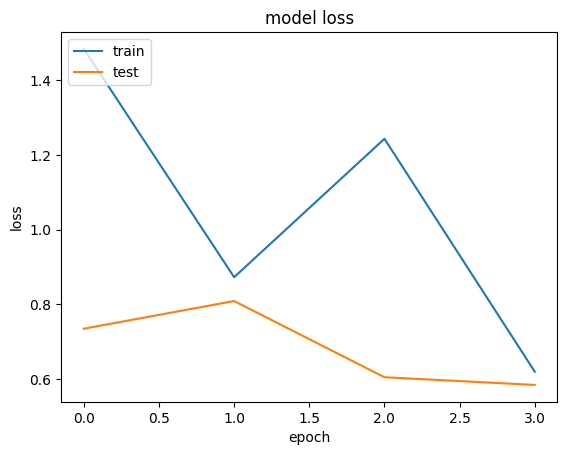

In [ ]:
#모델 학습중 손실에 대한 시각화 : 모델의 진행상황 및 과적합 여부 파악 가능
plt.plot(history2.history["loss"]) #훈련 데이터 손실값 그래프  / 각 epoch 마다의 훈련 데이터 손실값
plt.plot(history2.history["val_loss"]) #검증 데이터에 대한 손실값 그래프 / 각 학습에폭마다의 손실값
plt.title("model loss") # 그래프 제목
plt.ylabel("loss") # y축 레이블
plt.xlabel("epoch") # x축 레이블
plt.legend(["train", "test"], loc="upper left") #그래프에 범례 추가
plt.show() # 그래프 표시

#학습이 진행됨에 따라 손실이 감소하는 것이 이상적이며, 손실이 증가하면 과적합 가능성 고려

## 상위 10개 BOOK asin 출력하기

In [ ]:
reviewer_id = pd.DataFrame(df_kd["reviewerID"].unique()).reset_index(drop=True).loc[0,0]

In [ ]:
reviewer_id

'AUSBN91MCI3WM'

In [ ]:
df_kd.head()

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,reviewer,asinno
869697,869697,B00J4S6YWC,"[0, 0]",5.0,ARC provided by author in exchange for an hone...,"06 21, 2014",AUSBN91MCI3WM,Nancy M,A Very Sexy Cruise,1403308800,41203,54296
760913,760913,B00HCZUBH8,"[2, 4]",5.0,Wild Ride by Nancy WarrenChanging Gears Series...,"03 3, 2014",A141H51I3H4B1S,Jutzie,A Changing Gears Novel,1393804800,645,47453
159841,159841,B006RZNR3Y,"[0, 0]",5.0,"Well thought out story, with many things going...","07 10, 2014",AP8TKDM76TROZ,azbill54,"We don't take kindly to ""no""!",1404950400,10358,10421
868915,868915,B00J47H8H8,"[3, 4]",3.0,This is book four of a five part serial. By n...,"03 21, 2014",A19DWIC1T7127Y,T,I'm losing interest,1395360000,20546,54247
980703,980703,B00LRZLRMM,"[0, 0]",5.0,I really enjoyed this book. It kept me interes...,"07 14, 2014",AM5P5MI4PU2KH,Vida,Boner Brothers,1405296000,54684,61795


In [ ]:

#무작위로 선택한 reviewerID를 reviewer_id 변수에 저장

#선택한 사용자가 시청한 영화 목록을 movies_watched_by_user 데이터프레임에 저장
book_read_user = df_kd[df_kd.reviewerID == reviewer_id]

#사용자가 아직 읽지 않은 책 asin 추출
book_not_read = df_kd [
    ~df_kd["asin"].isin(book_read_user.asin.values)]["asin"]

#리뷰어가 아직 읽지 않은 책 중에서 모델이 인식하는 책 asin 목록 추출
book_not_read = list(
    set(book_not_read).intersection(set(asin_encoded.keys()))
)

#모델이 사용하는 asin에 해당하는 인덱스를 찾아 book_not_read를 업데이트
book_not_read = [[asin_encoded.get(x)] for x in book_not_read]

#리뷰어ID에 해당하는 인코딩데이터 불러오기
review_encoder = rv_encoded.get(reviewer_id)

#리뷰어와 아직 보지 않은 책에 대한 입력 배열을 생성
reviewer_book = np.hstack(
    ([[review_encoder]] * len(book_not_read), book_not_read)
)

#모델을 사용하여 리뷰어가 보지 않은 책에 대한 예상 평점 계산
overall = model.predict(reviewer_book).flatten()

#예상 평점이 가장 높은 상위 10개의 영화를 선택
top_10 = overall.argsort()[-10:][::-1]

#선택한 10개 책의 asin을 recommended_book_ids에 저장합니다.
recommended_book_ids = [
    asin_encoded2asin.get(book_not_read[x][0]) for x in top_10
]


1935/1935 [==============================] - 5s 3ms/step


In [ ]:
print("----" * 20)
print("Top 10 book recommendations for {}".format(reviewer_id))
print("----" * 20)
recommended_book_ids

--------------------------------------------------------------------------------
Top 10 book recommendations for AUSBN91MCI3WM
--------------------------------------------------------------------------------


['B00ID7K5CA',
 'B00JMORESG',
 'B008VIKVTI',
 'B00GN8K6CU',
 'B008K7LF8Q',
 'B00KY8G61A',
 'B00AAMJRDY',
 'B00LUAM4HG',
 'B009S9VRS8',
 'B00FPW0JFE']